# Game Description Analysis and ESRB Rating Prediction

## Dataset fetched from RAWG API - https://rawg.io/apidocs

##### This work compares different approaches to [predicting ESRB ratings based on game content descriptors](esrb_rating_classification.ipynb) within this project. The goal is to evaluate how well a model for predicting ESRB ratings can perform when the data is not well-structured, unlike the data used in the previous project. This is important because when new game title data is obtained, it is more likely to be in the form of unstructured data, such as game descriptions.

# Start the experiment with dataset load from the csv file

In [1]:
# Import necessary libraries

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk


 # Data Cleaning and Preprocessing

## Download NLTK Stopwords

In [2]:
# Download and prepare stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
extra_stopwords = {'game', 'play', 'new', 'world'}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd
# load the app_details_df from the csv file

app_details_df = pd.read_csv('../data/merged_games_data.csv')
# show the first 5 rows of the data
app_details_df.head()

,id,name,esrb_rating,description
0,3498,Grand Theft Auto V,Mature,"<p>Rockstar Games went bigger, since their pre..."
1,3328,The Witcher 3: Wild Hunt,Mature,"<p>The third game in a series, it holds nothin..."
2,4200,Portal 2,Everyone 10+,<p>Portal 2 is a first-person puzzle game deve...
3,4291,Counter-Strike: Global Offensive,Mature,<p>Counter-Strike is a multiplayer phenomenon ...
4,5286,Tomb Raider (2013),Mature,<p>A cinematic revival of the series in its ac...


## Define the Text Cleaning Function

### Text Cleaning Function
This function performs several steps:
- Removes HTML tags while keeping the text content.
- Handles multilingual content by removing non-English sections.
- Lowercases the text, removes punctuation, stopwords, and applies stemming.


In [4]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to clean HTML, multilingual content, and further clean the text
def clean_and_process_text(text):
    # Parse HTML content
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")

    # Handle multilingual content (e.g., removing non-English text)
    cleaned_text = re.split(r'\bEspañol\b', cleaned_text)[0]
    
    # Lowercase the text
    cleaned_text = cleaned_text.lower()
    
    # Remove punctuation
    cleaned_text = ''.join([char for char in cleaned_text if char not in string.punctuation])
    
    # Tokenize and remove stopwords
    tokens = cleaned_text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming and remove extra stopwords
    tokens = [stemmer.stem(word) for word in tokens if word not in extra_stopwords and not word.isdigit()]
    
    return ' '.join(tokens)


### Apply Text Cleaning
Here, we apply the text cleaning function to the `description` column of the dataset to produce a cleaned version of the text.


In [5]:
# Apply the cleaning and processing function
app_details_df['final_cleaned_description'] = app_details_df['description'].apply(clean_and_process_text)


C:\Users\barak\AppData\Local\Temp\ipykernel_19316\1988212502.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\barak\AppData\Local\Temp\ipykernel_19316\1988212502.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Save Cleaned Data
The cleaned text data is saved to a new CSV file for future use.


In [6]:
# Save the cleaned dataset to a CSV file
app_details_df.to_csv('../data/cleaned_app_details.csv', index=False)


### Tokenization
We tokenize the cleaned descriptions to prepare for word frequency analysis and other exploratory data analysis (EDA).


In [7]:
# Tokenization for further analysis
def tokenize(text):
    return text.lower().split()

app_details_df['tokens'] = app_details_df['final_cleaned_description'].apply(tokenize)


### Exploratory Data Analysis (EDA) - Word Frequency and Text Length
In this cell, we analyze the word frequency and text length distribution of the cleaned descriptions. The results are visualized using bar plots and histograms.


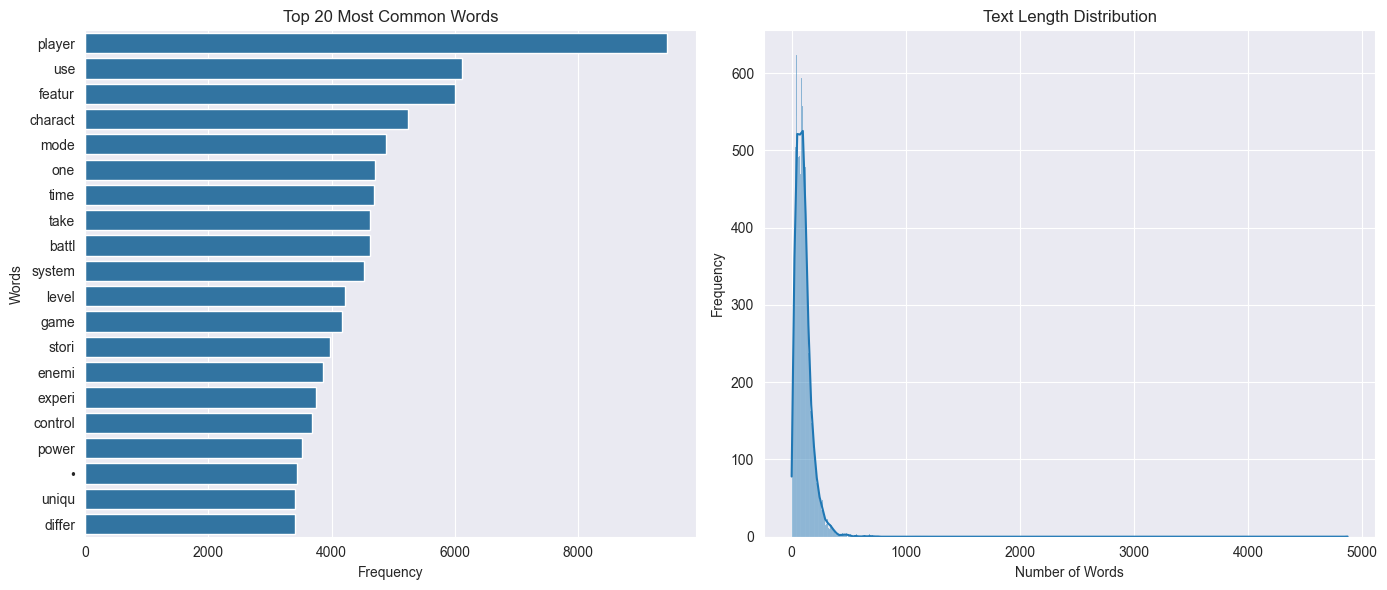

In [8]:
# Word Frequency Analysis
all_words = [word for tokens in app_details_df['tokens'] for word in tokens]
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Text Length Distribution
app_details_df['description_length'] = app_details_df['final_cleaned_description'].apply(lambda x: len(x.split()))

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot word frequency
words, counts = zip(*common_words)
sns.barplot(x=list(counts), y=list(words), ax=axes[0])
axes[0].set_title('Top 20 Most Common Words')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

# Plot text length distribution
sns.histplot(app_details_df['description_length'], kde=True, ax=axes[1])
axes[1].set_title('Text Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Word Cloud Visualization
We create a word cloud to visualize the most common words in the game descriptions, providing an intuitive overview of the dataset's content.


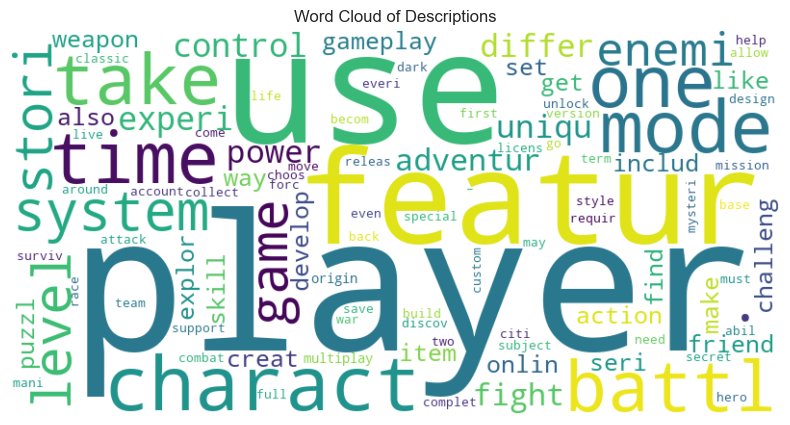

In [9]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()


### Final Processing - Further Cleaning and Analysis
In this final step, we further clean the tokens by removing extra stopwords, punctuation, and numbers, and applying stemming. We then analyze the most common words in the fully cleaned text.

In [10]:
# Final Processing - Removing Stopwords Again and Cleaning Further
def further_clean_tokens(tokens):
    # Remove punctuation and numbers, and apply stemming
    cleaned_tokens = [
        stemmer.stem(word) 
        for word in tokens 
        if word not in string.punctuation 
        and word not in extra_stopwords 
        and not word.isdigit()
    ]
    return cleaned_tokens

app_details_df['tokens_fully_cleaned'] = app_details_df['tokens'].apply(further_clean_tokens)
app_details_df['description_fully_cleaned'] = app_details_df['tokens_fully_cleaned'].apply(lambda x: ' '.join(x))

# Show the top 20 most common words after full cleaning
all_words_fully_cleaned = [word for tokens in app_details_df['tokens_fully_cleaned'] for word in tokens]
word_freq_fully_cleaned = Counter(all_words_fully_cleaned)
common_words_fully_cleaned = word_freq_fully_cleaned.most_common(20)

# Display the most common words after full cleaning
print(common_words_fully_cleaned)



[('player', 9442), ('use', 6117), ('featur', 5997), ('charact', 5255), ('mode', 4888), ('one', 4703), ('time', 4689), ('take', 4618), ('battl', 4617), ('system', 4534), ('level', 4221), ('stori', 3973), ('enemi', 3857), ('experi', 3818), ('control', 3688), ('power', 3515), ('•', 3442), ('uniqu', 3413), ('differ', 3400), ('fight', 3292)]


['Mature' 'Everyone 10+' 'Teen' 'Adults Only' 'Everyone' 'Rating Pending']


<Axes: xlabel='esrb_rating'>

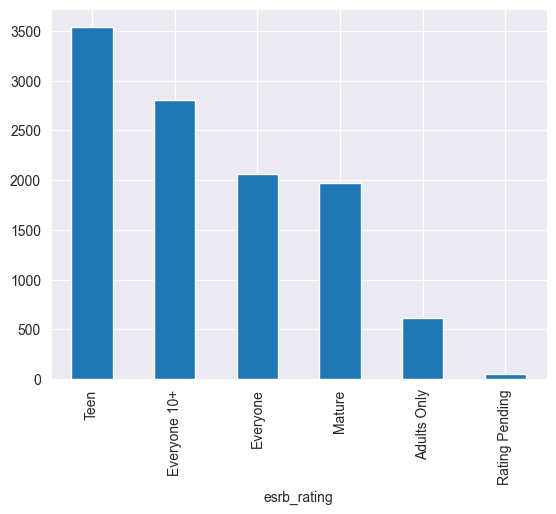

In [11]:
# show 'esrb_rating' column unique values
print(app_details_df['esrb_rating'].unique())

# show 'esrb_rating' column distribution
app_details_df['esrb_rating'].value_counts()
# plot the distribution of 'esrb_rating' column
app_details_df['esrb_rating'].value_counts().plot(kind='bar')

(7573, 9)


<Axes: xlabel='esrb_rating'>

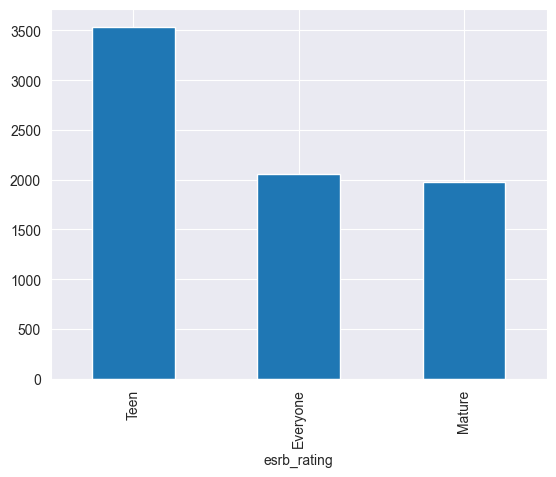

In [12]:
# keep only the data for Mature, Everyone, and Teen
app_details_df = app_details_df[app_details_df['esrb_rating'].isin(['Mature', 'Everyone', 'Teen'])]

# show the shape of the data
print(app_details_df.shape)

# show the distribution of 'esrb_rating' column
app_details_df['esrb_rating'].value_counts()

# even the distribution of the data
app_details_df['esrb_rating'].value_counts().plot(kind='bar')

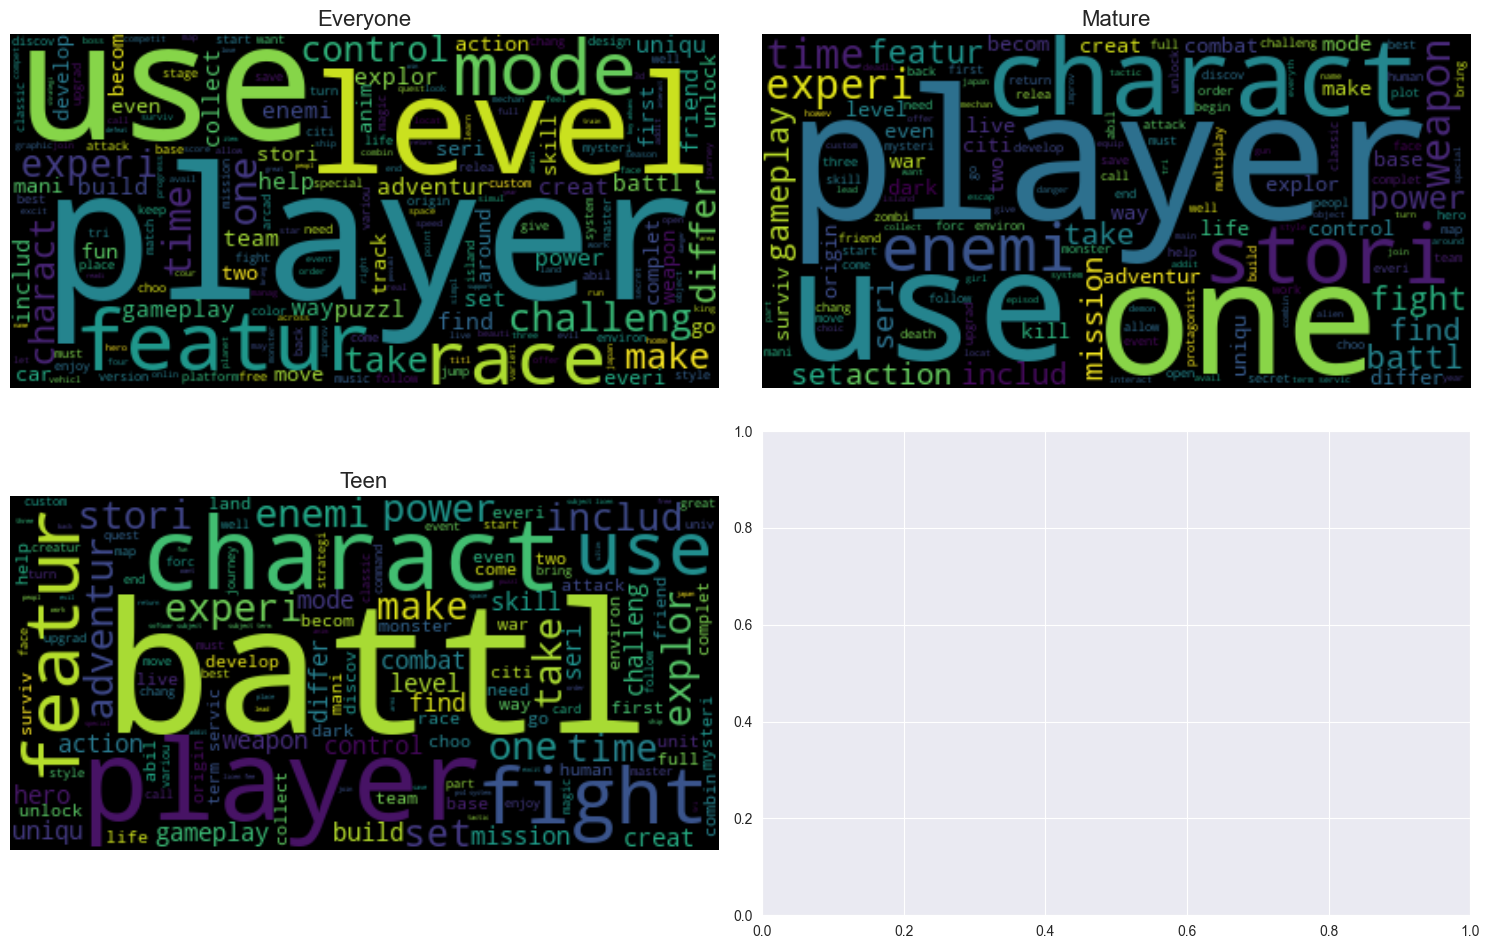

In [13]:
import wordcloud
from wordcloud import WordCloud

# Function to plot word clouds for each ESRB rating
def world_cloud_plot():
    esrb_rating_group = app_details_df.groupby('esrb_rating')['description_fully_cleaned'].apply(lambda x: ' '.join(x))
    
    # plot world cloud for each pair items esrb_group
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for (esrb_rating, descriptions), ax in zip(esrb_rating_group.items(), axes.flatten()):
        wordcloud = WordCloud(width=400, height=200).generate(descriptions)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{esrb_rating}', fontsize=16)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


world_cloud_plot()

# Even the distribution of the data

In [14]:


# make the distribution of the data even
# get the minimum count of the 'esrb_rating' column
min_count = app_details_df['esrb_rating'].value_counts().min()

# # sample the data for each 'esrb_rating' to the minimum count
app_details_df_even = app_details_df.groupby('esrb_rating').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


# show the shape of the data
print(app_details_df_even.shape)

# show the distribution of 'esrb_rating' column
app_details_df_even['esrb_rating'].value_counts()


(5925, 9)


esrb_rating
Everyone    1975
Mature      1975
Teen        1975
Name: count, dtype: int64

In [15]:
# change each of the labels to be the first letter
app_details_df_even['esrb_rating'] = app_details_df_even['esrb_rating'].apply(lambda x: x[0])

# show the distribution of 'esrb_rating' column
app_details_df_even['esrb_rating'].value_counts()

app_details_df_even.head()

,id,name,esrb_rating,description,final_cleaned_description,tokens,description_length,tokens_fully_cleaned,description_fully_cleaned
0,24337,Disney Epic Mickey,E,<p>Disney Epic Mickey is an action-adventure p...,disney epic mickey actionadventur platform wii...,"[disney, epic, mickey, actionadventur, platfor...",152,"[disney, epic, mickey, actionadventur, platfor...",disney epic mickey actionadventur platform wii...
1,42500,Tiny Thief,E,<p>Tiny Thief is an independent puzzle adventu...,tini thief independ puzzl adventur need contro...,"[tini, thief, independ, puzzl, adventur, need,...",71,"[tini, thief, independ, puzzl, adventur, need,...",tini thief independ puzzl adventur need contro...
2,356602,Little Alchemy 2,E,"Little Alchemy, the crafting game enjoyed by m...",littl alchemi craft enjoy million player back ...,"[littl, alchemi, craft, enjoy, million, player...",45,"[littl, alchemi, craft, enjoy, million, player...",littl alchemi craft enjoy million player back ...
3,284674,Totally Reliable Delivery Service,E,Buckle up your back brace and fire up the deli...,buckl back brace fire deliveri truck time deli...,"[buckl, back, brace, fire, deliveri, truck, ti...",83,"[buckl, back, brace, fire, deliveri, truck, ti...",buckl back brace fire deliveri truck time deli...
4,57333,Demon's Crest (1994),E,"<p>Demon&#39;s Crest, known in Japan as Demon&...",demon crest known japan demon blazon sidescrol...,"[demon, crest, known, japan, demon, blazon, si...",37,"[demon, crest, known, japan, demon, blazon, si...",demon crest known japan demon blazon sidescrol...


# Convert Text to Features

# TF-IDF Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the cleaned text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(app_details_df_even['description_fully_cleaned'])

# Define the target variable
y = app_details_df_even['esrb_rating']


# Count Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert the cleaned text to count features
vectorizer = CountVectorizer(max_features=5000)
X_count = vectorizer.fit_transform(app_details_df_even['description_fully_cleaned'])


# Model Evaluation

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split the dataset into train and test sets for both vectorization
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, app_details_df_even['esrb_rating'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, app_details_df_even['esrb_rating'], test_size=0.2, random_state=42)


def evaluate_model(X_train, y_train, X_test, y_test, model, model_name="Model", display_confusion_matrix=True):
    """
    Trains and evaluates a machine learning model, printing the accuracy and classification report,
    and displaying a confusion matrix heatmap.
    
    Parameters:
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Testing features.
    - y_test: Testing labels.
    - model: The machine learning model to train and evaluate.
    - model_name: A string representing the name of the model for display purposes.
    - display_confusion_matrix: Boolean to control whether to display the confusion matrix heatmap.
    
    Returns:
    - model: The trained model.
    """
    print(f'{model_name} using Tf-Idf')

    # Train the model
    model.fit(X_train, y_train)

    # ------------ Training Data Evaluation -----------------------
    predictions_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    print("Training Accuracy:", accuracy_train)

    # ------------ Test Data Evaluation -----------------------
    predictions_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, predictions_test)
    print("Test Accuracy:", accuracy_test)

    # Get classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions_test))

    # Confusion matrix
    if display_confusion_matrix:
        cm = confusion_matrix(y_test, predictions_test)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                    xticklabels=y_train.unique(), yticklabels=y_train.unique())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix Heatmap - {model_name}')
        plt.xticks(rotation=20)
        plt.yticks(rotation=20)
        plt.show()
    
    return model


Logistic Regression (TF-IDF) using Tf-Idf
Training Accuracy: 0.8721518987341772
Test Accuracy: 0.6616033755274262

Classification Report:
              precision    recall  f1-score   support

           E       0.78      0.71      0.74       418
           M       0.67      0.72      0.70       392
           T       0.53      0.54      0.54       375

    accuracy                           0.66      1185
   macro avg       0.66      0.66      0.66      1185
weighted avg       0.67      0.66      0.66      1185



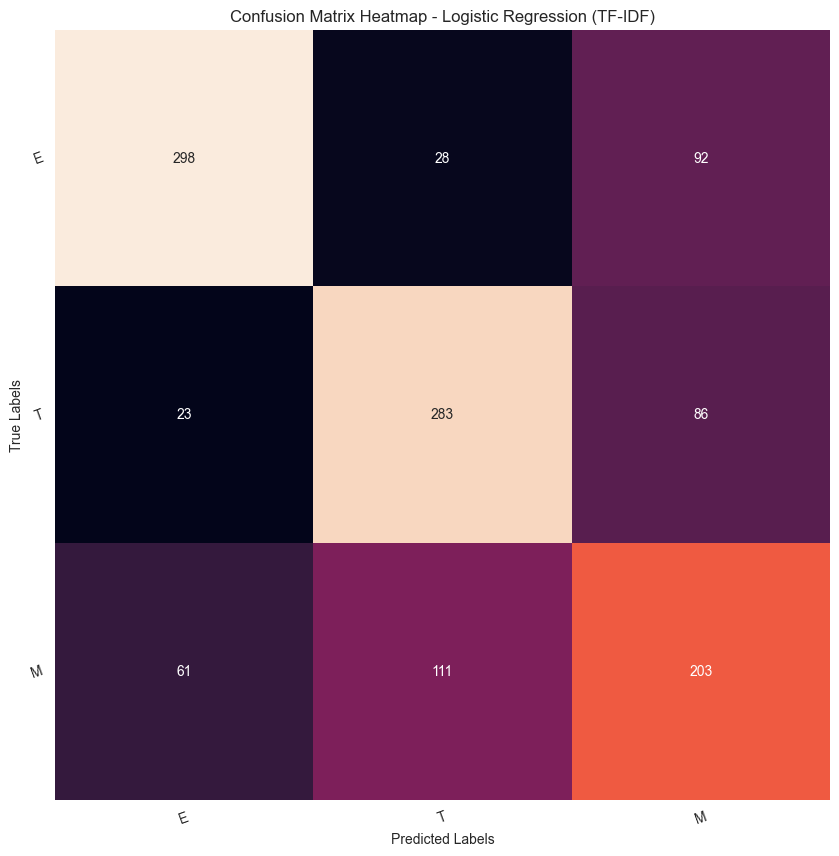

LogisticRegression(max_iter=1000)

In [35]:
# Logistic Regression using TF-IDF
lr_tfidf_classifier = LogisticRegression(max_iter=1000)
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, lr_tfidf_classifier, model_name="Logistic Regression (TF-IDF)")


Logistic Regression (CountVectorizer) using Tf-Idf
Training Accuracy: 0.99915611814346
Test Accuracy: 0.5949367088607594

Classification Report:
              precision    recall  f1-score   support

           E       0.70      0.68      0.69       418
           M       0.63      0.62      0.62       392
           T       0.45      0.47      0.46       375

    accuracy                           0.59      1185
   macro avg       0.59      0.59      0.59      1185
weighted avg       0.60      0.59      0.60      1185



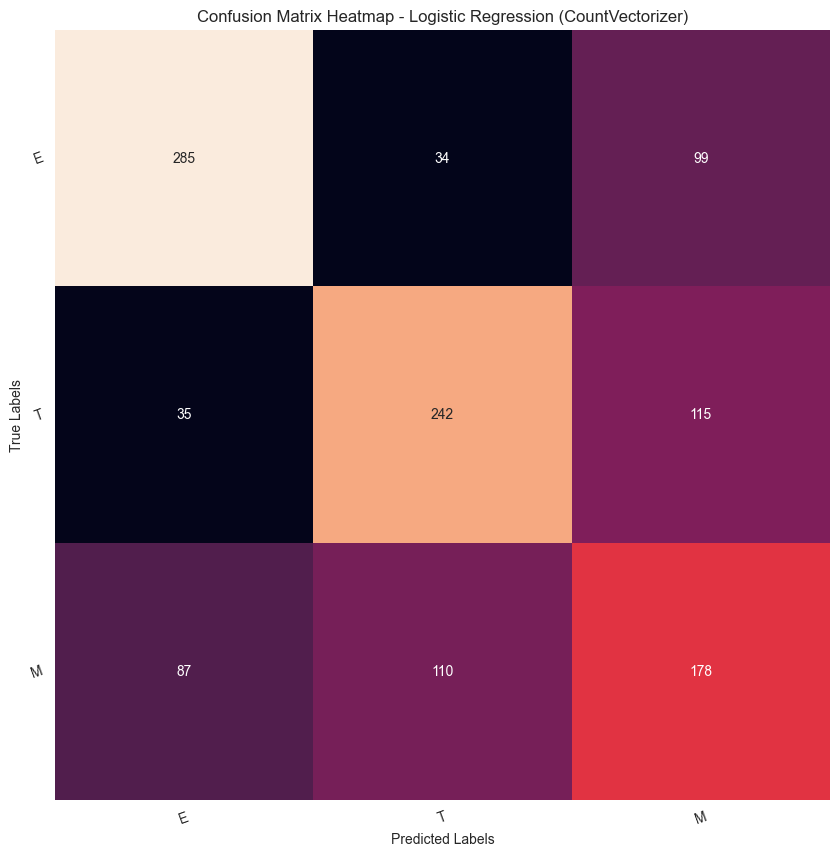

LogisticRegression(max_iter=1000)

In [36]:
# Logistic Regression using CountVectorizer
lr_count_classifier = LogisticRegression(max_iter=1000)
evaluate_model(X_train_count, y_train, X_test_count, y_test, lr_count_classifier, model_name="Logistic Regression (CountVectorizer)")

In [37]:
# save the model to a file
import joblib

# Save the model to a file
joblib.dump(lr_tfidf_classifier, '../models/esrb_classification_model_lr_tfidf.pkl')
joblib.dump(lr_count_classifier, '../models/esrb_classification_model_lr.pkl')


['../models/esrb_classification_model_lr.pkl']

Decision Tree (TF-IDF) using Tf-Idf
Training Accuracy: 0.999789029535865
Test Accuracy: 0.5172995780590718

Classification Report:
              precision    recall  f1-score   support

           E       0.62      0.58      0.60       418
           M       0.52      0.50      0.51       392
           T       0.42      0.46      0.44       375

    accuracy                           0.52      1185
   macro avg       0.52      0.52      0.52      1185
weighted avg       0.52      0.52      0.52      1185



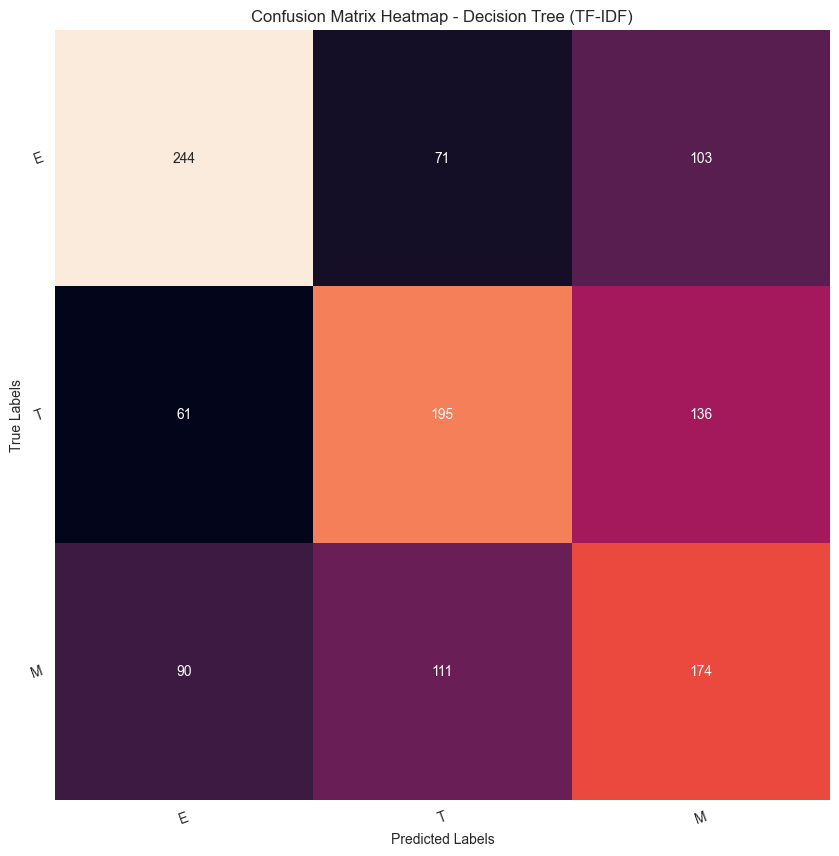

DecisionTreeClassifier()

In [38]:
# Decision Tree using TF-IDF
dt_tfidf_classifier = DecisionTreeClassifier()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, dt_tfidf_classifier, model_name="Decision Tree (TF-IDF)")

Decision Tree (CountVectorizer) using Tf-Idf
Training Accuracy: 0.999789029535865
Test Accuracy: 0.48523206751054854

Classification Report:
              precision    recall  f1-score   support

           E       0.59      0.58      0.58       418
           M       0.47      0.46      0.47       392
           T       0.39      0.41      0.40       375

    accuracy                           0.49      1185
   macro avg       0.48      0.48      0.48      1185
weighted avg       0.49      0.49      0.49      1185



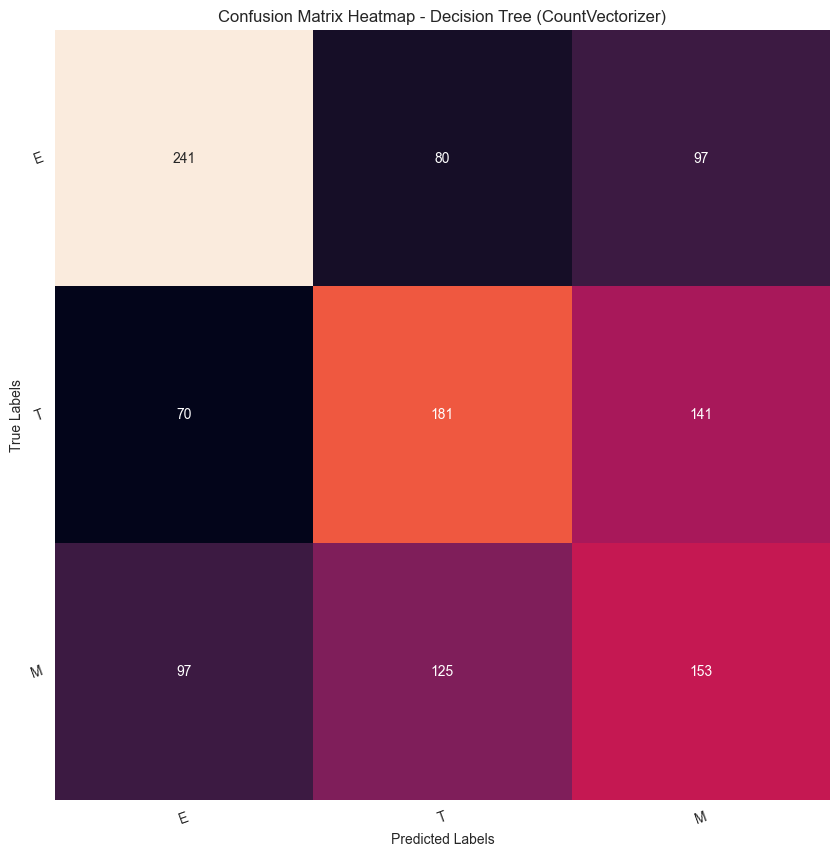

DecisionTreeClassifier()

In [39]:
# Decision Tree using CountVectorizer
dt_count_classifier = DecisionTreeClassifier()
evaluate_model(X_train_count, y_train, X_test_count, y_test, dt_count_classifier, model_name="Decision Tree (CountVectorizer)")

In [40]:
# Save the SVM model to a file
joblib.dump(dt_tfidf_classifier, '../models/esrb_classification_model_dt_tfidf.pkl')
joblib.dump(dt_count_classifier, '../models/esrb_classification_model_dt.pkl')

['../models/esrb_classification_model_dt.pkl']

Random Forest (TF-IDF) using Tf-Idf
Training Accuracy: 0.999789029535865
Test Accuracy: 0.6548523206751055

Classification Report:
              precision    recall  f1-score   support

           E       0.74      0.73      0.74       418
           M       0.64      0.73      0.68       392
           T       0.57      0.49      0.53       375

    accuracy                           0.65      1185
   macro avg       0.65      0.65      0.65      1185
weighted avg       0.65      0.65      0.65      1185



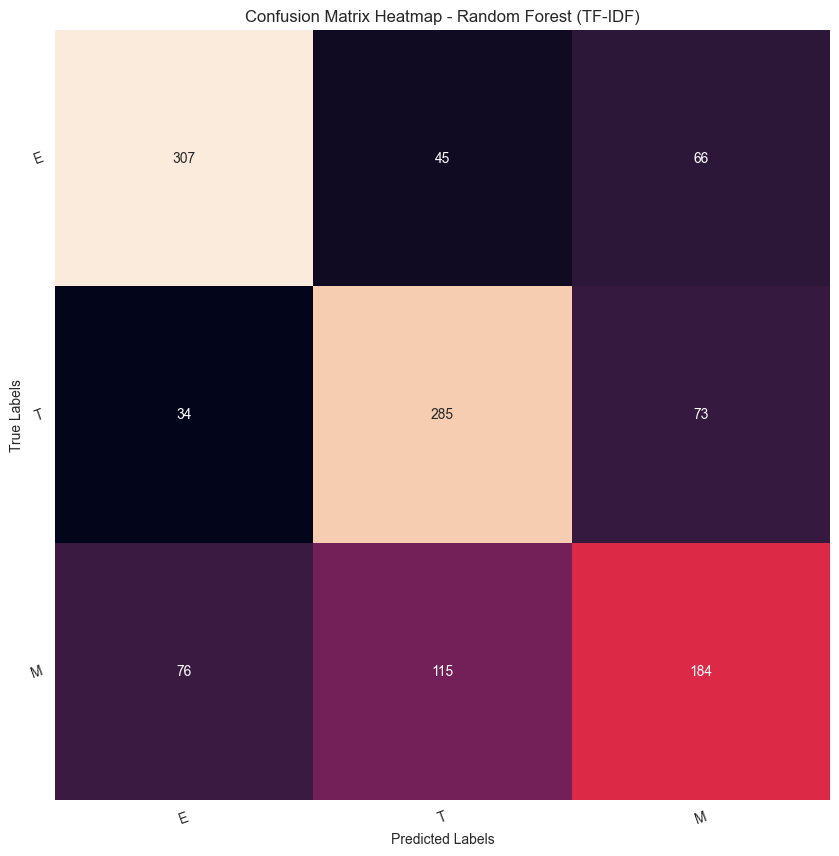

RandomForestClassifier()

In [41]:
# try Random Forest model

# Random Forest using TF-IDF
rf_model = RandomForestClassifier()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, rf_model, model_name="Random Forest (TF-IDF)")


Random Forest (CountVectorizer) using Tf-Idf
Training Accuracy: 0.999789029535865
Test Accuracy: 0.6573839662447257

Classification Report:
              precision    recall  f1-score   support

           E       0.74      0.75      0.75       418
           M       0.64      0.70      0.67       392
           T       0.57      0.51      0.54       375

    accuracy                           0.66      1185
   macro avg       0.65      0.65      0.65      1185
weighted avg       0.65      0.66      0.66      1185



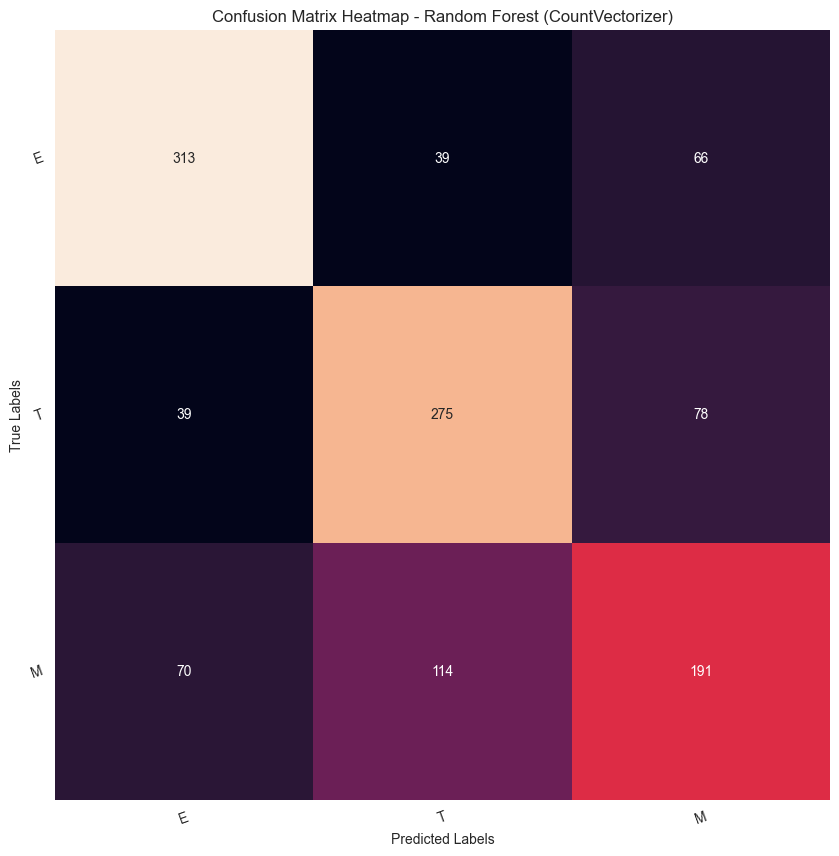

RandomForestClassifier()

In [42]:
# Random Forest using CountVectorizer
rf_model = RandomForestClassifier()
evaluate_model(X_train_count, y_train, X_test_count, y_test, rf_model, model_name="Random Forest (CountVectorizer)")


In [43]:
# Save the Random Forest model to a file
joblib.dump(rf_model, '../models/esrb_classification_model_rf_tfidf.pkl')
joblib.dump(rf_model, '../models/esrb_classification_model_rf.pkl')



['../models/esrb_classification_model_rf.pkl']

# K-Nearest Neighbors

K-Nearest Neighbors (TF-IDF) using Tf-Idf
Training Accuracy: 0.3837552742616034
Test Accuracy: 0.37383966244725736

Classification Report:
              precision    recall  f1-score   support

           E       0.36      0.98      0.53       418
           M       0.58      0.02      0.03       392
           T       0.67      0.07      0.13       375

    accuracy                           0.37      1185
   macro avg       0.54      0.36      0.23      1185
weighted avg       0.53      0.37      0.24      1185



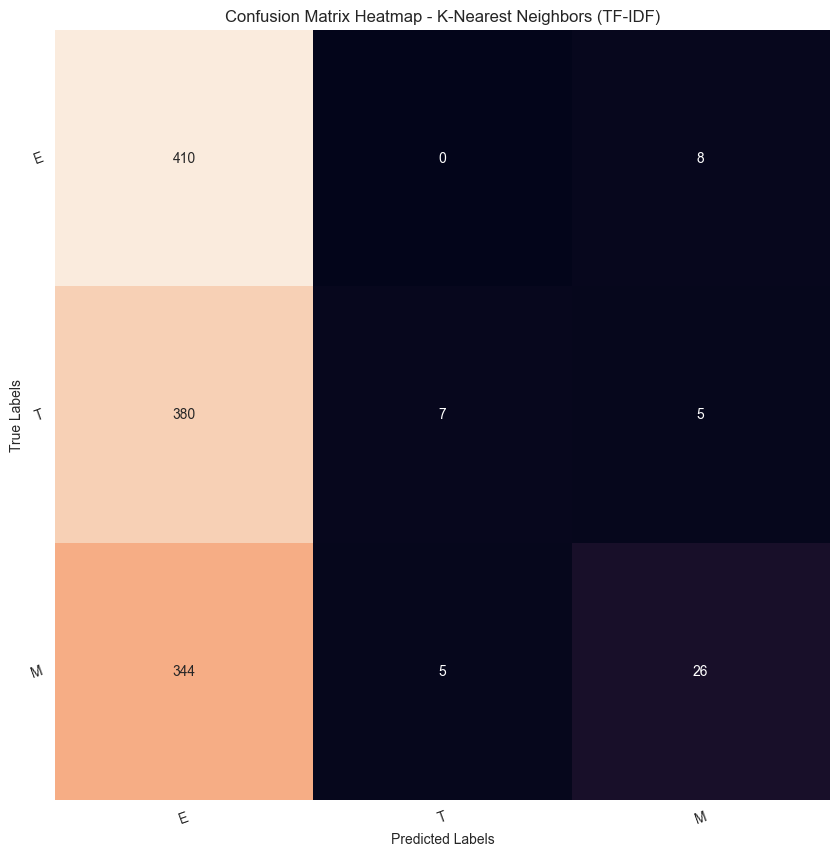

KNeighborsClassifier()

In [44]:
# K-Nearest Neighbors using TF-IDF
knn_tfidf_classifier = KNeighborsClassifier()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, knn_tfidf_classifier, model_name="K-Nearest Neighbors (TF-IDF)")


K-Nearest Neighbors (CountVectorizer) using Tf-Idf
Training Accuracy: 0.520464135021097
Test Accuracy: 0.42362869198312236

Classification Report:
              precision    recall  f1-score   support

           E       0.39      0.88      0.54       418
           M       0.54      0.14      0.23       392
           T       0.52      0.21      0.30       375

    accuracy                           0.42      1185
   macro avg       0.49      0.41      0.36      1185
weighted avg       0.48      0.42      0.36      1185



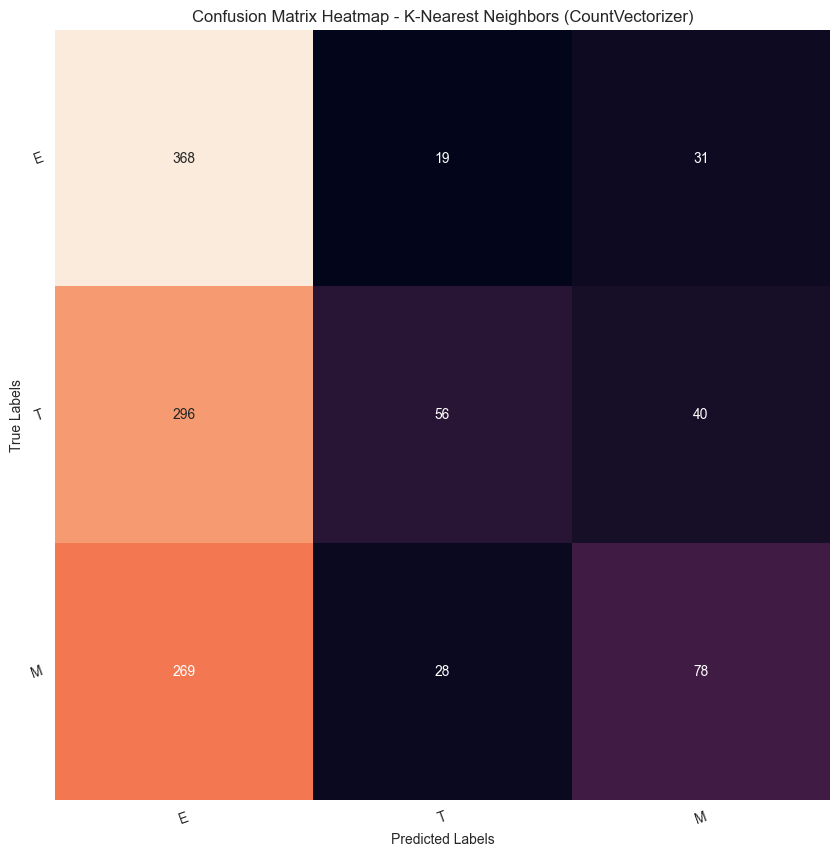

KNeighborsClassifier()

In [45]:
# K-Nearest Neighbors using CountVectorizer
knn_count_classifier = KNeighborsClassifier()
evaluate_model(X_train_count, y_train, X_test_count, y_test, knn_count_classifier, model_name="K-Nearest Neighbors (CountVectorizer)")

In [46]:
# Save the K-Nearest Neighbors model to a file
joblib.dump(knn_tfidf_classifier, '../models/esrb_classification_model_knn_tfidf.pkl')
joblib.dump(knn_count_classifier, '../models/esrb_classification_model_knn.pkl')

['../models/esrb_classification_model_knn.pkl']

# Support Vector Machine

Support Vector Machine (TF-IDF) using Tf-Idf
Training Accuracy: 0.9822784810126582
Test Accuracy: 0.6852320675105485

Classification Report:
              precision    recall  f1-score   support

           E       0.80      0.72      0.76       418
           M       0.71      0.73      0.72       392
           T       0.56      0.60      0.58       375

    accuracy                           0.69      1185
   macro avg       0.69      0.68      0.68      1185
weighted avg       0.69      0.69      0.69      1185



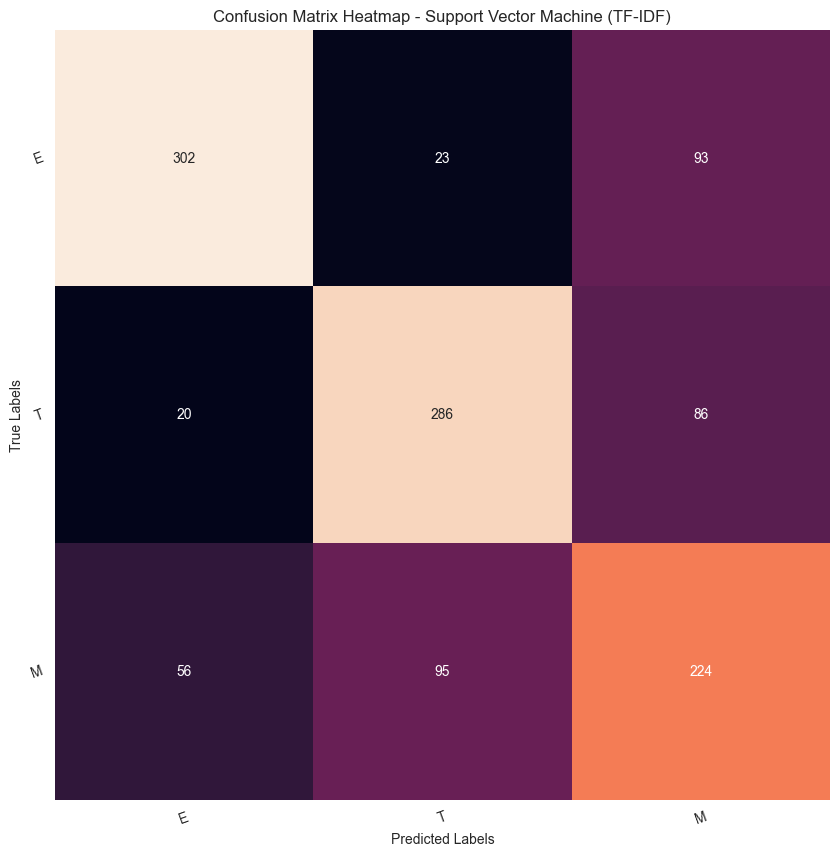

SVC()

In [47]:
# try Support Vector Machine model
# SVM using TF-IDF
svm_tfidf_classifier = SVC()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, svm_tfidf_classifier, model_name="Support Vector Machine (TF-IDF)")

Support Vector Machine (CountVectorizer) using Tf-Idf
Training Accuracy: 0.9023206751054852
Test Accuracy: 0.6514767932489451

Classification Report:
              precision    recall  f1-score   support

           E       0.75      0.72      0.74       418
           M       0.68      0.66      0.67       392
           T       0.53      0.57      0.55       375

    accuracy                           0.65      1185
   macro avg       0.65      0.65      0.65      1185
weighted avg       0.66      0.65      0.65      1185



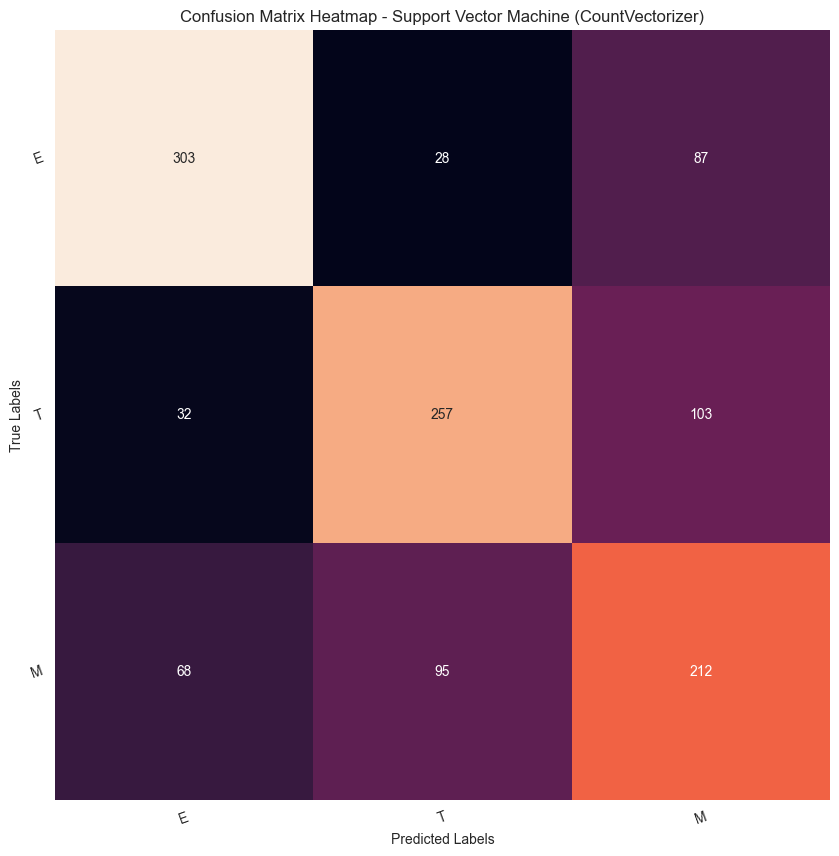

SVC()

In [48]:
# SVM using CountVectorizer
svm_count_classifier = SVC()
evaluate_model(X_train_count, y_train, X_test_count, y_test, svm_count_classifier, model_name="Support Vector Machine (CountVectorizer)")

In [49]:
import pandas as pd

# Create an empty list to store the results
results_list = []

# Logistic Regression
results_list.append({
    'Model': 'Logistic Regression',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, lr_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, lr_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Logistic Regression',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, lr_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, lr_count_classifier.predict(X_test_count))
})

# Decision Tree
results_list.append({
    'Model': 'Decision Tree',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, dt_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, dt_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Decision Tree',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, dt_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, dt_count_classifier.predict(X_test_count))
})

# K-Nearest Neighbors
results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, knn_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, knn_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, knn_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, knn_count_classifier.predict(X_test_count))
})

# Support Vector Machine
results_list.append({
    'Model': 'Support Vector Machine',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, svm_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, svm_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Support Vector Machine',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, svm_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, svm_count_classifier.predict(X_test_count))
})

# Random Forest
results_list.append({
    'Model': 'Random Forest',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, rf_model.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, rf_model.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Random Forest',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, rf_model.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, rf_model.predict(X_test_count))
})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)


                    Model       Vectorizer  Training Accuracy  Test Accuracy
0     Logistic Regression           TF-IDF           0.872152       0.661603
1     Logistic Regression  CountVectorizer           0.999156       0.594937
2           Decision Tree           TF-IDF           0.999789       0.517300
3           Decision Tree  CountVectorizer           0.999789       0.485232
4     K-Nearest Neighbors           TF-IDF           0.383755       0.373840
5     K-Nearest Neighbors  CountVectorizer           0.520464       0.423629
6  Support Vector Machine           TF-IDF           0.982278       0.685232
7  Support Vector Machine  CountVectorizer           0.902321       0.651477
8           Random Forest           TF-IDF           0.329747       0.352743
9           Random Forest  CountVectorizer           0.999789       0.657384


# Conclusion
- In this notebook, we performed an analysis of game descriptions and ESRB ratings. We cleaned the text data, analyzed word frequency, visualized the data using word clouds, and prepared the text for machine learning models. We trained and evaluated several models using both TF-IDF and CountVectorizer for text vectorization.

### Observations:

#### TF-IDF vs. CountVectorizer:

- **TF-IDF**:
  - Tends to perform better with models like Logistic Regression and SVM, which benefit from the discriminative power of features that TF-IDF provides.
  - These models are better at generalizing to unseen data when using TF-IDF, as it reduces the impact of common but less informative words.

- **CountVectorizer**:
  - Shows higher training accuracy across most models, often leading to overfitting.
  - This method may result in capturing noise or irrelevant patterns, particularly in models like Decision Trees and Random Forests.

#### Model Selection:

- **SVM with TF-IDF**:
  - Appears to be the best-performing combination, providing a good balance between training and test accuracy.

- **Logistic Regression with TF-IDF**:
  - Also performs well, making it a reliable choice for this task.

- **Decision Tree and Random Forest**:
  - Show strong tendencies to overfit, especially with CountVectorizer, suggesting that more regularization or alternative methods might be needed.
